In [1]:
%matplotlib inline

# Modèle de classification des stades du sommeil

Les étapes de notre modèle sont suivantes:
- Données:
  - Sélectionner au hasard des epocs de 30 secondes pour une électrode pour un individu avec leur étiquette afin d'avoir lot de données d'**entraînement**, <s>de **test** (pour l'ajustement des paramètres du modèle)</s> et de **validation** (pour évaluer la qualité du modèle). 
- Preprocessing:
  - Transformation dans le domaine fréquentiel de chaque epoc de 30 secondes
  - <s>Réduction de la taille du jeu de données et amoindrir la multicolinéarité:
    - Application de la PCA (ou SVD)</s>
- Établir les amplitudes moyennes de chaque stade de sommeil dans le domaine fréquentiel.
- Prédiction en se basant sur la distance euclidéenne dans le domaine fréquentiel des epocs. 



In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

## Données

On fait d'abord l'acquisition des données de MNE, puis on sélectionne que les données qui nous intéressent, c'est-à-dire qu'un électrode de données EEG.

Voir: https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.equalize_event_counts

In [3]:
SUBJECTS = [1,2]
NIGHT_RECORDINGS = [1, 2]

subject_files = fetch_data(subjects=SUBJECTS, recording=NIGHT_RECORDINGS)
print(subject_files)
raw_data = mne.io.read_raw_edf(subject_files[0][0], preload=True)
print(raw_data)

NUMBER_CHANNELS = raw_data.info["nchan"]
LOWPASS_FILTER = raw_data.info["lowpass"]
SAMPLING_FREQ = raw_data.info["sfreq"]

print("The corresponding file has %i channels, has a low pass filter of %i Hz and a sampling rate of %i Hz." % (NUMBER_CHANNELS, LOWPASS_FILTER, SAMPLING_FREQ))
print("The channels are ", raw_data.info["ch_names"])

mapping = {'EEG Fpz-Cz': 'eeg',
           'EEG Pz-Oz': 'eeg',
           'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_data.set_channel_types(mapping)

Using default location ~/mne_data for PHYSIONET_SLEEP...
[['/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4011E0-PSG.edf', '/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4011EH-Hypnogram.edf'], ['/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4012E0-PSG.edf', '/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4012EC-Hypnogram.edf'], ['/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4021E0-PSG.edf', '/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4021EH-Hypnogram.edf'], ['/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4022E0-PSG.edf', '/Users/claudiaonorato/mne_data/physionet-sleep-data/SC4022EJ-Hypnogram.edf']]
Extracting EDF parameters from /Users/claudiaonorato/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
<RawEDF  |  SC4011E0-PSG.edf, n_channels x n_times : 7 x 8406000 (84060.0 sec), ~448.9 MB,

Effective window size : 20.480 (s)


<ipython-input-4-df37753fdfc5>:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.plot_psd(fmax=LOWPASS_FILTER)


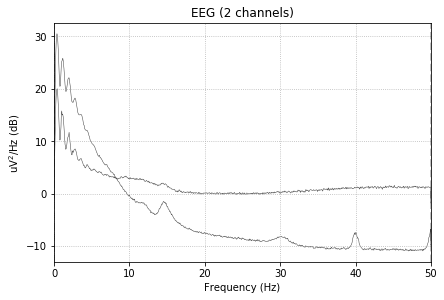

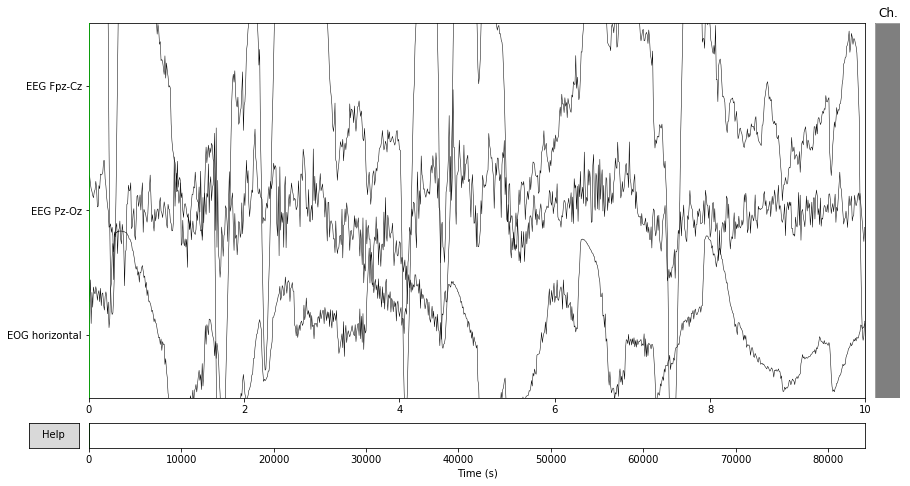

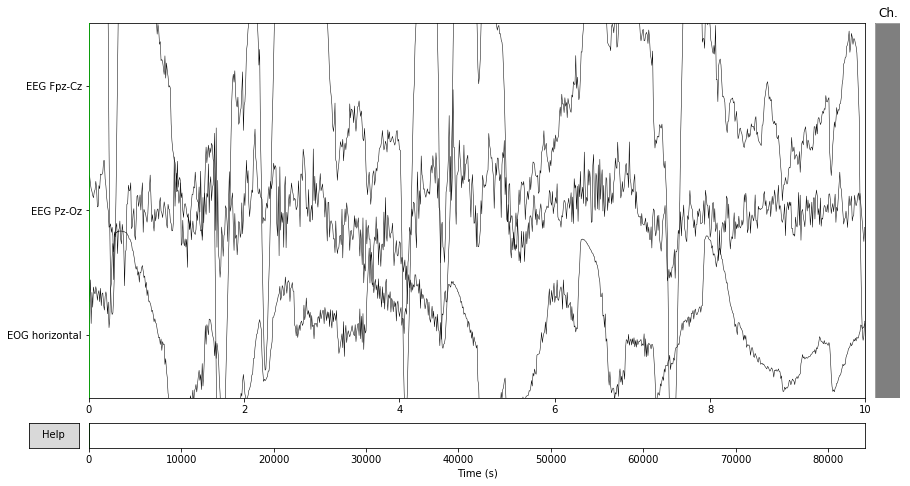

In [4]:
if raw_data.info["nchan"] != 3:
    raw_data.drop_channels(['Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'])

raw_data.plot_psd(fmax=LOWPASS_FILTER)
raw_data.plot(duration=10)

### Affichage de la classification des epochs

Ajout des annotations des données aux données brutes et visualisation de celles-ci. On crée ensuite une liste d'`Epoch`, classe sur laquelle on peut appliquer de nombreuses opérations dans la librairie de MNE.

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


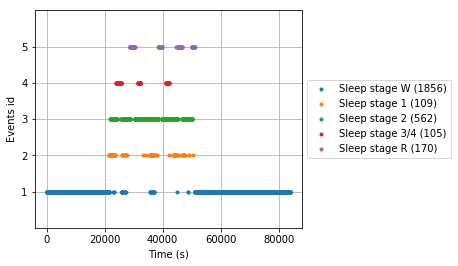

In [5]:
EPOCH_DURATION = 30. # in seconds

subject1_annotations = mne.read_annotations(subject_files[0][1])
raw_data.set_annotations(subject1_annotations, emit_warning=False)

annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

events_train, _ = mne.events_from_annotations(
    raw_data, event_id=annotation_desc_2_event_id, chunk_duration=EPOCH_DURATION)

event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
mne.viz.plot_events(events_train, event_id=event_id,
                    sfreq=SAMPLING_FREQ)

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
# We want to get all the data within a [0, 30[ seconds interval period.
tmax = 30. - 1. / raw_data.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_data, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

2802 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   2802 events (good & bad), 0 - 29.99 sec, baseline off, ~11 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 1856>


### Fonction récapitulative pour l'extraction de données

De ce qui précède, une fonction qui permet d'accéder aux informations importantes et aux données nécessaires au traitement à partir un enregistrement suit.

In [7]:
CHANNELS = {
  'EEG Fpz-Cz': 'EEG Fpz-Cz',
  'EEG Pz-Oz': 'EEG Pz-Oz',
  'EOG horizontal': 'EOG horizontal',
  'Resp oro-nasal': 'Resp oro-nasal',
  'EMG submental': 'EMG submental',
  'Temp rectal': 'Temp rectal',
  'Event marker': 'Event marker'
}

MAPPING = {
  CHANNELS['EEG Fpz-Cz']: 'eeg',
  CHANNELS['EEG Pz-Oz']: 'eeg',
  CHANNELS['EOG horizontal']: 'eog',
  CHANNELS['Resp oro-nasal']: 'misc',
  CHANNELS['EMG submental']: 'misc',
  CHANNELS['Temp rectal']: 'misc',
  CHANNELS['Event marker']: 'misc'
}

ANNOTATIONS_EVENT_ID = {
  'Sleep stage W': 1,
  'Sleep stage 1': 2,
  'Sleep stage 2': 3,
  'Sleep stage 3': 4,
  'Sleep stage 4': 4,
  'Sleep stage R': 5
}

EVENT_ID = {
  'Sleep stage W': 1,
  'Sleep stage 1': 2,
  'Sleep stage 2': 3,
  'Sleep stage 3/4': 4,
  'Sleep stage R': 5
}


def retrieve_raw(subject=0, night=1):
    subject_file = fetch_data(subjects=[subject], recording=[night])
    raw_data = mne.io.read_raw_edf(subject_file[0][0], preload=True)
    raw_data.set_channel_types(MAPPING)
    raw_data.drop_channels([dropped_chan for dropped_chan in CHANNELS.values() if dropped_chan is not(CHANNELS['EEG Fpz-Cz'] or CHANNELS['EEG Pz-Oz'])])

    annotations = mne.read_annotations(subject_file[0][1])
    raw_data.set_annotations(annotations, emit_warning=False)

    return raw_data


def create_epochs(raw_data, epoch_duration=30, equalize_event=False):
    events, _ = mne.events_from_annotations(raw_data, event_id=ANNOTATIONS_EVENT_ID, chunk_duration=epoch_duration)
    tmax = 30. - 1. / raw_data.info['sfreq']  # tmax in included
    epochs = mne.Epochs(raw=raw_data, events=events, event_id=EVENT_ID, tmin=0., tmax=tmax, baseline=None)
    epochs.drop_bad()
    return epochs
    # return epochs.equalize_event_counts(EVENT_ID.keys())[0] if equalize_event else epochs


In [8]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # UTILISER PCA PEUT-ȨTRE MEILLEUR, CAR C.L. DES FRÉQ. AVEC LE PLUS D'INFOS
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for i in np.arange(0.5, 30, 0.5):
        psds_band = psds[:, :, (freqs >= i) & (freqs < i+0.5)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    # for fmin, fmax in FREQ_BANDS.values():
    #     psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    #     X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

### Nettoyage après l'analyse exploratoire

In [9]:
del epochs_train, raw_data, events_train

# Classification

Ensuite, nous allons tenter de faire la classification des ondes du sommeil à l'aide d'un random forest pour les deux situations suivantes:

1. Les epochs d'entrainement pour chaque classe sont prises au hasard parmis tous les sujets et les epochs de validation sont aussi prises au hasard parmis tous les sujets. L'entrainement est donc effectué sur des sujets qui tenteront de valider leurs données.

2. Les epochs d'entrainement proviennent de sujet qui ne sont pas les mêmes que ceux pour lesquels nous tenterons de prédire les données du sommeil (epochs de validation proviennent de sujet différents).

Pour commencer, nous prendrons un **nombre égal d'epoch pour chaque classe**. 80% des epochs seront utilisées pour l'entrainement et 20% pour la validation.

In [10]:
# Fonction qui imite train_test_split de sklearn, mais qui permet de toujours conserver les objets Epochs à la place d'utiliser de convertir celles-ci vers des array.
# Cela allège considérablement le code.

def create_sets(epochs, training_set=0.70, test_set=0.15, validation_set=0.15):
    """ Randomly splits epochs in different sets """
    if (training_set + test_set + validation_set) != 1:
        raise Exception("Percentages invalid")

    TRAINING_EPOCHS_LEN = int(training_set*len(epochs))
    TEST_EPOCHS_LEN = int((test_set)*len(epochs))
    
    epoch_indexes = set(range(len(epochs)))
    training_epochs_indexes = set(random.sample(epoch_indexes, TRAINING_EPOCHS_LEN))
    epoch_indexes -= training_epochs_indexes
    test_epochs_indexes = set(random.sample(epoch_indexes, TEST_EPOCHS_LEN))
    epoch_indexes -= test_epochs_indexes
    validation_epochs_indexes = set(epoch_indexes)
    
    """
    training_epochs = [epochs[idx] for idx in training_epochs_indexes]
    test_epochs = [epochs[idx] for idx in test_epochs_indexes]
    validation_epochs = [epochs[idx] for idx in validation_epochs_indexes]
    del epochs
    
    resulted_sets = {
        "TRAINING" : mne.concatenate_epochs(training_epochs) if len(training_epochs) else None,
        "TEST": mne.concatenate_epochs(test_epochs) if len(test_epochs) else None,
        "VALIDATION": mne.concatenate_epochs(validation_epochs) if len(validation_epochs) else None
    }
    """
    epoch_indexes = set(range(len(epochs)))
    training_epochs = epochs.copy().drop(list(epoch_indexes - training_epochs_indexes))
    test_epochs = epochs.copy().drop(list(epoch_indexes - test_epochs_indexes))
    validation_epochs = epochs.drop(list(epoch_indexes - validation_epochs_indexes))
    
    resulted_sets = {
        "TRAINING" : training_epochs,
        "TEST": test_epochs,
        "VALIDATION": validation_epochs
    }
    
    return resulted_sets

# Voir https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html si on ne fait que concaténer toutes les epochs dans un même array.

In [17]:
SUBJECTS = 19

epochs = []
for subject in range(SUBJECTS):
    s = time.time()
    raw = retrieve_raw(subject,1)
    print("retrieve_raw exec time: %f" % (time.time() - s))

    s = time.time()
    epochs.append(create_epochs(raw, equalize_event=True)) 
    print("create_epochs exec time: %f" % (time.time() - s))

s = time.time()
epochs = mne.concatenate_epochs(epochs)
print("concatenate_epochs exec time: %f" % (time.time() - s))

del raw

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/claudiaonorato/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
retrieve_raw exec time: 2.199641
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2650 events and 3000 original time points ...
0 bad epochs dropped
create_epochs exec time: 0.904819
Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/claudiaonorato/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
retri

In [18]:
s = time.time()
sets = create_sets(epochs, training_set=0.70, test_set=0.15, validation_set=0.15)
print("create_sets exec time: %f" % (time.time() - s))

print(sets)

Dropped 15544 epochs
Dropped 44042 epochs
Dropped 44040 epochs
create_sets exec time: 4.838461
{'TRAINING': <Epochs  |   36269 events (all good), 0 - 29.99 sec, baseline off, ~830.1 MB, data loaded,
 'Sleep stage 1': 790
 'Sleep stage 2': 5867
 'Sleep stage 3/4': 1985
 'Sleep stage R': 2434
 'Sleep stage W': 25193>, 'TEST': <Epochs  |   7771 events (all good), 0 - 29.99 sec, baseline off, ~177.9 MB, data loaded,
 'Sleep stage 1': 169
 'Sleep stage 2': 1284
 'Sleep stage 3/4': 469
 'Sleep stage R': 519
 'Sleep stage W': 5330>, 'VALIDATION': <Epochs  |   7773 events (all good), 0 - 29.99 sec, baseline off, ~177.9 MB, data loaded,
 'Sleep stage 1': 163
 'Sleep stage 2': 1216
 'Sleep stage 3/4': 417
 'Sleep stage R': 517
 'Sleep stage W': 5460>}


In [13]:
del raw

In [19]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=300, max_depth=14, random_state=42))

# Training
y_train = sets['TRAINING'].events[:, 2]
pipe.fit(sets['TRAINING'], y_train)

# Validation
y_pred = pipe.predict(sets['VALIDATION'])

# Assess the results
y_true = sets['VALIDATION'].events[:, 2]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=event_id.keys()))

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
[[5413    2   12    0   33]
 [ 115    3   20    0   25]
 [ 148    0  977   57   34]
 [  26    0   65  326    0]
 [ 246    1   62    1  207]]
                 precision    recall  f1-score   support

  Sleep stage W       0.91      0.99      0.95      5460
  Sleep stage 1       0.50      0.02      0.04       163
  Sleep stage 2       0.86      0.80      0.83      1216
Sleep stage 3/4       0.85      0.78      0.81       417
  Sleep stage R       0.69      0.40      0.51       517

       accuracy                           0.89      7773
      macro avg       0.76      0.60      0.63      7773
   weighted avg       0.88      0.89      0.87      7773



In [20]:
# Test
y_pred = pipe.predict(sets['TEST'])

# Assess the results
y_true = sets['TEST'].events[:, 2]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=event_id.keys()))

Effective window size : 2.560 (s)
7771 7771
[[5281    0   13    5   31]
 [ 119    1   20    0   29]
 [ 156    0 1041   47   40]
 [  32    0   82  355    0]
 [ 240    1   49    0  229]]
                 precision    recall  f1-score   support

  Sleep stage W       0.91      0.99      0.95      5330
  Sleep stage 1       0.50      0.01      0.01       169
  Sleep stage 2       0.86      0.81      0.84      1284
Sleep stage 3/4       0.87      0.76      0.81       469
  Sleep stage R       0.70      0.44      0.54       519

       accuracy                           0.89      7771
      macro avg       0.77      0.60      0.63      7771
   weighted avg       0.87      0.89      0.87      7771



# Régression Logistique

In [14]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     LogisticRegression(C=1e11, solver='lbfgs', multi_class='multinomial'))

# Training
y_train = sets['TRAINING'].events[:, 2]
y_proba = pipe.fit(sets['TRAINING'], y_train).predict_proba(sets['VALIDATION'])

# Test
y_pred = pipe.predict(sets['VALIDATION'])

# Assess the results
y_test = sets['VALIDATION'].events[:, 2]

acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))


Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Accuracy score: 0.7838827838827839


/home/william/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [15]:
print(confusion_matrix(y_test, y_pred))

[[548   1  15   8   7]
 [ 17   3   2   1   1]
 [ 49   1  57   1   1]
 [ 37   0   0  20   0]
 [ 31   1   4   0  14]]


In [16]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.80      0.95      0.87       579
  Sleep stage 1       0.50      0.12      0.20        24
  Sleep stage 2       0.73      0.52      0.61       109
Sleep stage 3/4       0.67      0.35      0.46        57
  Sleep stage R       0.61      0.28      0.38        50

       accuracy                           0.78       819
      macro avg       0.66      0.45      0.50       819
   weighted avg       0.76      0.78      0.76       819



In [17]:
# Test
y_pred = pipe.predict(sets['TEST'])

# Assess the results
y_true = sets['TEST'].events[:, 2]

print(len(y_true), len(y_pred))

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=event_id.keys()))

Effective window size : 2.560 (s)
817 817
[[540   1  11   9   8]
 [ 21   2   2   0   3]
 [ 47   2  68   1   2]
 [ 36   0   0  16   1]
 [ 24   1   2   0  20]]
                 precision    recall  f1-score   support

  Sleep stage W       0.81      0.95      0.87       569
  Sleep stage 1       0.33      0.07      0.12        28
  Sleep stage 2       0.82      0.57      0.67       120
Sleep stage 3/4       0.62      0.30      0.41        53
  Sleep stage R       0.59      0.43      0.49        47

       accuracy                           0.79       817
      macro avg       0.63      0.46      0.51       817
   weighted avg       0.77      0.79      0.77       817



# Références

Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/cgi/content/full/101/23/e215]; 2000 (June 13).